# 1. Setup Mario

In [1]:
import numpy as np

In [12]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [11]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [12]:
done = True
# Loop through each frame in the game
for frame in range(100000):
    if done:
        # Start the game
        env.reset()
    # Take random actions
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
env.close()

2024-01-14 21:57:17.240 Python[54989:8471910] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/yg/hjwnxjxn51n5m36kvf822s940000gp/T/org.python.python.savedState


In [ ]:
env.close()

# 2. Preprocess Environment

In [13]:
from gym.wrappers import FrameStack, GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [10]:
# Create Base Environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# Simplify Controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# Wrap inside dummy environment
env = DummyVecEnv([lambda: env])
# Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [14]:
state = env.reset()

In [15]:
state.shape

(1, 240, 256, 4)

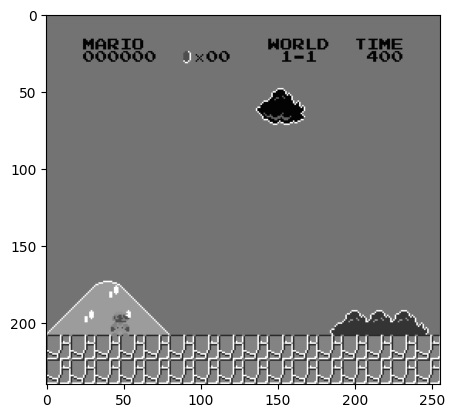

In [17]:
plt.imshow(state[0])

# 3. Train RL Model

In [5]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [6]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [7]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [8]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [11]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [14]:
model.learn(total_timesteps=10000000, callback=callback)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/matthew.yough/Library/Python/3.9/lib/python/site-packages/tensorboard/compat/__init__.py", line 42, in tf
    from tensorboard.compat import notf  # noqa: F401
ImportError: cannot import name 'notf' from 'tensorboard.compat' (/Users/matthew.yough/Library/Python/3.9/lib/python/site-packages/tensorboard/compat/__init__.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/matthew.yough/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 2142, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/matthew.yough/Library/Python/3.9/lib/python/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/matthew.yough/Library/Python/3.9/lib/python/site-packages/IPython/core/ultratb.py", line 1326, in structured_traceback
    return VerboseTB.s

AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

# 4. Test it Out

In [17]:
model = PPO.load('./train/best_model_20000')

In [18]:
state = env.reset()
while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

2024-01-13 14:03:47.292 Python[2058:6552761] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/yg/hjwnxjxn51n5m36kvf822s940000gp/T/org.python.python.savedState
